## Preface



First, if you don&rsquo;t already have the latest version of the `cfe` package
installed, grab it, along with some dependencies:



In [33]:
!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf 

Requirement already up-to-date: CFEDemands in /srv/app/venv/lib/python3.6/site-packages
You are using pip version 9.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: xarray in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: pandas>=0.25 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: numpy>=1.15 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: setuptools>=41.2 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: pytz>=2017.2 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: python-dateutil>=2.6.1 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: six>=1.5 in /srv/app/venv/lib/python3.6/site-packages (from python-dateutil>=2.6.1->pandas>=

Second, load relevant dataset:



In [34]:
import cfe

# Results can be made persistent by saving them, and then re-loading...
r = cfe.from_dataset('Ethiopia_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]  # Insist on alpha positive

## Choosing reference prices, budget, and units



We&rsquo;ll want to choose reference prices (a choice of `t` and `m`) and
units (`u`).  You can examine possibilities by looking at:



In [35]:
r.prices.coords

Coordinates:
  * i        (i) object 'Banana' 'Barley' 'Beef' ... 'Tella' 'Tomato' 'Wheat'
  * t        (t) int64 2011 2013 2015
  * m        (m) int64 1
  * u        (u) object '40' 'Araba' ... 'Zorba/Akara \xa0  Small'

Below we choose first market in first period, but this is a matter of
choice.  We also choose prices for goods measured in &rsquo;Kilograms&rsquo;; this
may vary with the dataset.  To inspect possible units look at:



In [36]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Note selection of prices for first market in first period for /kgs/.
# For goods never measured in kgs prices will be missing. 
p = r.prices.sel(t=t,m=m,u='Kg',drop=True).to_dataframe().squeeze().dropna()
p

/srv/app/venv/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/app/venv/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


i
Banana            2.138573
Barley           10.130627
Chat / Kat        4.360239
Cheese           38.000000
Chick Pea        19.950864
Coffee            0.182123
Eggs             17.000000
Haricot Beans     8.400000
Horsebeans       11.201397
Kocho             3.872905
Lentils          25.350303
Linseed           0.249102
Maize             1.606267
Meat              9.164968
Milk             16.000000
Millet            5.986486
Onion             1.899735
Potato            2.128150
Salt              0.028861
Sorghum           3.867222
Sugar             0.269821
Teff              6.893324
Wheat             7.693904
Name: prices, dtype: float64

And with $(x,p)$ defined we can calculate example demands:



In [37]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

i
Banana            2.252682
Barley            7.575711
Chat / Kat        3.188113
Chick Pea         1.389511
Coffee           33.331246
Eggs              0.160435
Haricot Beans     1.785131
Horsebeans        1.725570
Lentils           0.273692
Maize            21.901694
Milk              0.348218
Onion             2.194407
Potato            1.472625
Salt             68.543013
Sorghum          29.018355
Sugar            30.475477
Teff              1.963178
Wheat            12.618170
dtype: float64

## Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
quantities using `cfe.Result.demands`.  Next we want to think about
how to map these into bundles of *nutrients*.  The information needed
for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
such as the [USDA Food Central Database](https://fdc.nal.usda.gov/)).   Here we&rsquo;ve adapted (with
thanks to Alessandro Tarozzi of the Universitat Pompeu Fabra) a food
conversion table developed by Gopalan et al (1980) to the foods
reported in the Indian ICRISAT data:



In [38]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' sheet id to that of your own sheet
fct = dataframe_from_gspreadsheet("FCT", '1XuCmJTZOLT25gLO9uuo-_Sws6wiXCWkEbn1icnNGQM8')


# Change some labels
d={'Energy (kcal)':'Calories',
   'Protein (g)':'Protein',
   'Fiber, total dietary (g)':'Fiber',
   'Folate, DFE (μg)':'Folate',
   'Calcium, Ca (mg)':'Calcium',
   'Carbohydrate, by difference (g)':'Carbs',
   'Iron, Fe (mg)':'Iron',
   'Magnesium, Mg (mg)':'Magnesium',
   'Niacin (mg)':'Niacin',
   'Phosphorus, P (mg)':'Phosporus',
   'Potassium, K (mg)':'Potassium',
   'Riboflavin (mg)':'Riboflavin',
   'Thiamin (mg)':'Thiamin',
   'ascorbic_total':'Ascorbic Acid',
   'Vitamin A, RAE (μg)':'Vitamin A',
   'Vitamin B-12 (μg)':'Vitamin B12',
   'Vitamin B-6 (mg)':'Vitamin B6',
   'Vitamin C, total ascorbic acid (mg)':'Vitamin C',
   'Vitamin E (alpha-tocopherol) (mg)':'Vitamin E',
   'Vitamin K (phylloquinone) (μg)':'Vitamin K',
   'Zinc, Zn (mg)':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['i'].str.title()
del fct['i']
del fct['ext_source']

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

Index(['Calories', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbs', 'Iron',
       'Magnesium', 'Niacin', 'Phosporus', 'Potassium', 'Riboflavin',
       'Thiamin', 'Vitamin A', 'Vitamin B12', 'Vitamin B6', 'Vitamin C',
       'Vitamin E', 'Vitamin K', 'Zinc'],
      dtype='object')

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [39]:
# Create a new FCT and vector of consumption that only share rows in common:
fct = fct[~fct.index.duplicated()]
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)


Index(['Banana', 'Barley', 'Chat / Kat', 'Chick Pea', 'Eggs', 'Haricot Beans',
       'Horsebeans', 'Lentils', 'Maize', 'Milk', 'Onion', 'Potato', 'Salt',
       'Sorghum', 'Sugar', 'Teff', 'Wheat'],
      dtype='object', name='i')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [40]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Calories       37878.627280
Protein          832.790201
Fiber            650.782320
Folate          3743.510076
Calcium         3044.920803
Carbs           8478.525127
Iron             244.637358
Magnesium       6505.541998
Niacin           294.625305
Phosporus      19021.263232
Potassium      28099.985635
Riboflavin        14.287431
Thiamin           22.503196
Vitamin A        150.300059
Vitamin B12        0.305666
Vitamin B6        28.852608
Vitamin C        148.758398
Vitamin E         21.404228
Vitamin K        174.572413
Zinc             141.707672
dtype: float64

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [41]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



In [48]:
fct.loc['Chick Pea']['Iron'] = 16

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'log nutrient')

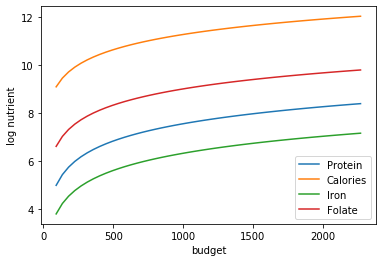

In [49]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Calories','Iron','Folate']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.plot(X,logN)
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient')

Now how does nutrition vary with prices at median income?



Text(0, 0.5, 'log Nutrient')

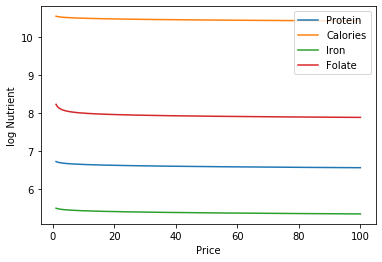

In [51]:
# Choose some good from your dataset
USE_GOOD = 'Chick Pea'

P = np.linspace(1,100,300).tolist()

plt.plot(P,pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Price')
plt.ylabel('log Nutrient')